In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Set up graphs
matplotlib.rcParams.update({'font.size': 11})

In [3]:
def allan_deviation(data, dt, npoints, minblocksize = 1, nmaxblock = 5, returnblocksizes = False):
    '''
    `allan_devation` calculates the Allan deviation of the array `data`.
    data should be evenly spaced in time with spacing `dt`
    `npoints` specifies the desired number of points in the output, the
         output will be logatithmically spaced and may have less than
         `npoints` if this would cause duplicates
    `minblocksize` sets the size of the smallest block in the Allan devation
        default = 1
    `nmaxblock` sets the number of blocks of the largest size. i.e. the size of
        the largest block will be `N//nmaxblock` where `N` is the length of data
        default = 5
    `returnblocksizes` set to true to also return the sizes of the blocks
    
    Returns:
    `tau` = the time span of each block the Allan deviation was calculated for
    `sigma` = the Allan deviation for each value of taus
    `blocksizes` = the size in points of each block
    '''
    if type(data) is list:
        data = np.asarray(data)
    assert type(data) is np.ndarray, 'data should be a list or numpy array'
    assert data.ndim == 1, 'data should be one dimensional'
    minblocksize = int(minblocksize)
    assert minblocksize > 0, 'minblocksize must be an integer of one or greater'
    nmaxblock = int(nmaxblock)
    assert nmaxblock > 1, 'nmaxblock must be an integer of two or greater'

    N = len(data)
    # make logaritmically spaced blocksizes
    # may be less than npoints as we remove non-unique values
    blocksizes = np.unique(np.round(np.logspace(np.log10(minblocksize), np.log10(N//nmaxblock), npoints)).astype(np.int))
    sigma = np.zeros(len(blocksizes))
    for j, blocksize in enumerate(blocksizes):
        M = N//blocksize
        blockmean = np.mean(data[0:(N//blocksize) * blocksize].reshape((-1, blocksize)), axis = 1)
        sigma[j] = np.sqrt(0.5 * np.mean(np.diff(blockmean)**2))

    tau = blocksizes * dt
    if returnblocksizes:
        return (tau, sigma, blocksizes)
    else:
        return (tau, sigma)

In [4]:
#Define the autocollimator zero position in pixels, the autocollimator calibration factor, and the number of seconds in an hour
zero_x = 848.54
zero_y = 540.77
calibration = 0.22193485237391664
seconds_per_hour = 3600.0

In [5]:
#Import ambient and air conditioned datasets, centre the peak spot positions about the mean of the dataset and convert them to measured angles. There is a 24 hours period between these subdatasets to allow the laboratory temperature to stabalise
df = pd.read_csv(r'../Data/autocollimator_drift_data_20210810_133916.txt', delimiter = ',', skipinitialspace = True, skiprows = 2)
df['Yaw (arcsec)'] = (df['Peak x position (px)'] - df['Peak x position (px)'].mean()) / calibration
df['Pitch (arcsec)'] = (df['Peak y position (px)'] - df['Peak y position (px)'].mean()) / calibration
t_max = df['Time (s)'].max()

Interval between frames: 1.028 +/- 0.032 s
Largest jitter: 0.139 s


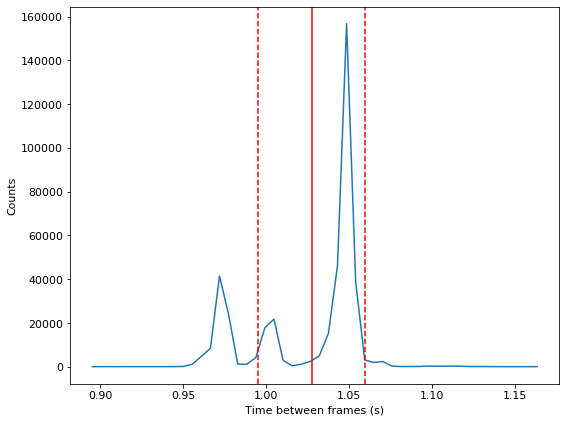

In [6]:
#Calculate and plot the average time per point and jitter
t = df['Time (s)'].copy().values
delta_t = np.diff(t)
dt = np.mean(delta_t)
largest_jitter = np.max(np.abs(delta_t)) - dt
dt_std = np.std(delta_t, ddof = 1)
print('Interval between frames: {:.3f} +/- {:.2g} s'.format(dt, dt_std))
print('Largest jitter: {:.3f} s'.format(largest_jitter))

n_bins = 50
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

hist, bins = np.histogram(delta_t, n_bins)
ax.plot(0.5 * (bins[1:] + bins[:-1]), hist)

ax.axvline(dt, color = 'r')
ax.axvline(dt - dt_std, color = 'r', linestyle = '--')
ax.axvline(dt + dt_std, color = 'r', linestyle = '--')

ax.set_xlabel('Time between frames (s)')
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

## Ambient dataset

In [7]:
df_ambient = df.copy()
df_ambient = df_ambient[df_ambient['Time (s)'] >= (t_max - (43.0 * 3600.0))]
df_ambient['Time (s)'] = df_ambient['Time (s)'] - df_ambient['Time (s)'].iloc[0]

In [8]:
#Calculate Allan deviation of temperaute and measured angles
x = df_ambient['Yaw (arcsec)'].copy().values
y = df_ambient['Pitch (arcsec)'].copy().values
temp = df_ambient['Temperature (°C)'].copy().values

tau_x_ambient, allan_x_ambient = allan_deviation(x, dt, 200)
tau_y_ambient, allan_y_ambient = allan_deviation(y, dt, 200)
tau_temp_ambient, allan_temp_ambient = allan_deviation(temp, dt, 200)

In [9]:
#For the angles measured under ambient conditions, find the gradient of the Allan deviation in loglog space over time scales longer than an hour
ix = np.argmax(tau_x_ambient > seconds_per_hour)
iy = np.argmax(tau_y_ambient > seconds_per_hour)
if ix == iy:
    print('Over time scales longer than 1 hour')

    coe = np.polyfit(np.log(tau_x_ambient[ix:]), np.log(allan_x_ambient[ix:]), 1)
    print('The gradient of the Allan variance for yaw is {:.2g}'
          .format(coe[0]))

    coe = np.polyfit(np.log(tau_y_ambient[ix:]), np.log(allan_y_ambient[ix:]), 1)
    print('The gradient of the Allan variance for pitch is {:.2g}'
          .format(coe[0]))

Over time scales longer than 1 hour
The gradient of the Allan variance for yaw is 0.54
The gradient of the Allan variance for pitch is 0.6


In [10]:
print('The minimum temperature is {:.2f}\u00b0C\n'
      'The maximum temperautre is {:.2f}\u00b0C'
      .format(df_ambient['Temperature (°C)'].min(), df_ambient['Temperature (°C)'].max()))

#For the measured angles, find the time scale over which the measurement noise averages out
ix_ambient = np.argmin(allan_x_ambient)
iy_ambient = np.argmin(allan_y_ambient)
print('Allan deviation for yaw minimises over a time scale of {:.2g} s\n'
      'Allan deviation for pitch minimises over a time scale of {:.2g} s'
      .format(tau_x_ambient[ix_ambient], tau_y_ambient[iy_ambient]))

The minimum temperature is 25.32°C
The maximum temperautre is 26.62°C
Allan deviation for yaw minimises over a time scale of 35 s
Allan deviation for pitch minimises over a time scale of 45 s


In [11]:
#Calculate the angular drift rates
x = df_ambient['Yaw (arcsec)'].copy().values
y = df_ambient['Pitch (arcsec)'].copy().values

#Points per hour and points per day
pph = int(seconds_per_hour // dt)
ppd = int((24.0 * seconds_per_hour) // dt)

yaw_drift_over_one_hour = np.abs(x[pph:] - x[:-pph])
yaw_drift_over_one_day = np.abs(x[ppd:] - x[:-ppd])
pitch_drift_over_one_hour = np.abs(y[pph:] - y[:-pph])
pitch_drift_over_one_day = np.abs(y[ppd:] - y[:-ppd])

print('Mean yaw drift over any hour: {:.2g} arcsec\n'
      'Mean yaw over any 24 hours: {:.2g} arcsec\n'
      'Mean pitch drift over any hour: {:.2g} arcsec\n'
      'Mean pitch drift over any 24 hours: {:.2g} arcsec'
      .format(np.mean(yaw_drift_over_one_hour),
              np.mean(yaw_drift_over_one_day),
              np.mean(pitch_drift_over_one_hour),
              np.mean(pitch_drift_over_one_day)))

Mean yaw drift over any hour: 0.33 arcsec
Mean yaw over any 24 hours: 2.4 arcsec
Mean pitch drift over any hour: 0.26 arcsec
Mean pitch drift over any 24 hours: 1.9 arcsec


## Air conditioned dataset

In [12]:
df_aircon = df.copy()
df_aircon = df_aircon[df_aircon['Time (s)'] <= (43.0 * 3600.0)]
df_aircon['Time (s)'] = df_aircon['Time (s)'] - df_aircon['Time (s)'].iloc[0]

In [13]:
#Calculate Allan deviation of temperaute and measured angles
x = df_aircon['Yaw (arcsec)'].copy().values
y = df_aircon['Pitch (arcsec)'].copy().values
temp = df_aircon['Temperature (°C)'].copy().values

tau_x_aircon, allan_x_aircon = allan_deviation(x, dt, 200)
tau_y_aircon, allan_y_aircon = allan_deviation(y, dt, 200)
tau_temp_aircon, allan_temp_aircon = allan_deviation(temp, dt, 200)

In [14]:
#Estimate the angular drift per degree Celcius when the air conditioner is switch on
temp_max = df_aircon['Temperature (°C)'].max()
temp_min = df_aircon['Temperature (°C)'].min()
yaw_max = df_aircon['Yaw (arcsec)'].max()
yaw_min = df_aircon['Yaw (arcsec)'].min()
pitch_max = df_aircon['Pitch (arcsec)'].max()
pitch_min = df_aircon['Pitch (arcsec)'].min()
yaw_drift_per_degree_celsius = (yaw_max - yaw_min) / (temp_max - temp_min)
pitch_drift_per_degree_celsius = (pitch_max - pitch_min) / (temp_max - temp_min)

print('The minimum temperature is {:.2f}\u00b0C\n'
      'The maximum temperautre is {:.2f}\u00b0C\n'
      'Yaw deviation per degree Celsius: {:.2f} arcsec\n'
      'Pitch deviation per degree Celsius: {:.2f} arcsec'
      .format(temp_min, temp_max, yaw_drift_per_degree_celsius, pitch_drift_per_degree_celsius))

The minimum temperature is 19.65°C
The maximum temperautre is 23.35°C
Yaw deviation per degree Celsius: 1.90 arcsec
Pitch deviation per degree Celsius: 1.64 arcsec


In [15]:
#For the measured angles, find the time scale over which the measurement noise averages out
ix_aircon = np.argmin(allan_x_aircon[:100])
iy_aircon = np.argmin(allan_y_aircon[:100])
print('Allan deviation for yaw minimises over a time scale of {:.2g} s\n'
      'Allan deviation for pitch minimises over a time scale of {:.2g} s'
      .format(tau_x_aircon[ix_aircon], tau_y_aircon[iy_aircon]))

Allan deviation for yaw minimises over a time scale of 3.1 s
Allan deviation for pitch minimises over a time scale of 3.1 s


In [16]:
#Calculate the angular drift rates
x = df_aircon['Yaw (arcsec)'].copy().values
y = df_aircon['Pitch (arcsec)'].copy().values

#Points per hour and points per day
pph = int(seconds_per_hour // dt)
ppd = int((24.0 * seconds_per_hour) // dt)

yaw_drift_over_one_hour = np.abs(x[pph:] - x[:-pph])
yaw_drift_over_one_day = np.abs(x[ppd:] - x[:-ppd])
pitch_drift_over_one_hour = np.abs(y[pph:] - y[:-pph])
pitch_drift_over_one_day = np.abs(y[ppd:] - y[:-ppd])

print('Mean yaw drift over any hour: {:.2g} arcsec\n'
      'Mean yaw over any 24 hours: {:.2g} arcsec\n'
      'Mean pitch drift over any hour: {:.2g} arcsec\n'
      'Mean pitch drift over any 24 hours: {:.2g} arcsec'
      .format(np.mean(yaw_drift_over_one_hour),
              np.mean(yaw_drift_over_one_day),
              np.mean(pitch_drift_over_one_hour),
              np.mean(pitch_drift_over_one_day)))

Mean yaw drift over any hour: 1.8 arcsec
Mean yaw over any 24 hours: 1.8 arcsec
Mean pitch drift over any hour: 0.67 arcsec
Mean pitch drift over any 24 hours: 0.74 arcsec


## Temperature stablised dataset

In [17]:
#Import the temperature stabalised dataset, centre the peak spot positions about the mean of the dataset and convert them to measured angles
df_box = pd.read_csv(r'../Data/autocollimator_drift_data_20220314_172858.txt', delimiter = ',', skipinitialspace = True, skiprows = 2)
df_box = df_box[df_box['Time (s)'] > (24.0 * 3600.0)]
df_box['Time (s)'] = df_box['Time (s)'] - df_box['Time (s)'].iloc[0]
df_box['Yaw (arcsec)'] = (df_box['Peak x position (px)'] - df_box['Peak x position (px)'].mean()) / calibration
df_box['Pitch (arcsec)'] = (df_box['Peak y position (px)'] - df_box['Peak y position (px)'].mean()) / calibration
df_box

Time (s)  Peak x position (px)  Peak y position (px)  \
183036       0.000000            859.083389            628.770106   
183037       0.457073            859.113717            628.762096   
183038       0.932180            859.088859            628.737288   
183039       1.410306            859.081635            628.748963   
183040       1.875171            859.111570            628.752823   
...               ...                   ...                   ...   
566141  183205.983778            859.306080            628.670752   
566142  183206.449616            859.327462            628.666267   
566143  183206.911401            859.306100            628.663755   
566144  183207.391907            859.288031            628.617203   
566145  183207.868512            859.324157            628.646776   

        Maximum pixel value  Temperature (°C)  Yaw (arcsec)  Pitch (arcsec)  
183036                  183         24.038682     -1.000684        0.474023  
183037                  185         24.025330     -0.864031        0.437932  
183038                  183         24.025330     -0.976039        0.326150  
183039                  184         24.025330     -1.008589        0.378757  
183040                  185         24.025330     -0.873707        0.396150  
...                     ...               ...           ...             ...  
566141                  173         24.068055      0.002723        0.026348  
566142                  175         24.052033      0.099068        0.006144  
566143                  176         24.052033      0.002812       -0.005176  
566144                  174         24.052033     -0.078602       -0.214932  
566145                  176         24.038682      0.084173       -0.081682  

[383110 rows x 7 columns]

Interval between frames: 0.478 +/- 0.012 s
Largest jitter: 1.250 s


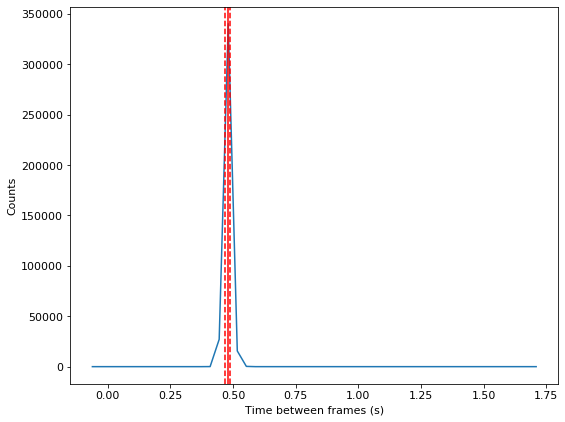

In [18]:
#Calculate and plot the average time per point and jitter
t = df_box['Time (s)'].copy().values
delta_t = np.diff(t)
dt = np.mean(delta_t)
largest_jitter = np.max(np.abs(delta_t)) - dt
dt_std = np.std(delta_t, ddof = 1)
print('Interval between frames: {:.3f} +/- {:.2g} s'.format(dt, dt_std))
print('Largest jitter: {:.3f} s'.format(largest_jitter))

n_bins = 50
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

hist, bins = np.histogram(delta_t, n_bins)
ax.plot(0.5 * (bins[1:] + bins[:-1]), hist)

ax.axvline(dt, color = 'r')
ax.axvline(dt - dt_std, color = 'r', linestyle = '--')
ax.axvline(dt + dt_std, color = 'r', linestyle = '--')

ax.set_xlabel('Time between frames (s)')
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

In [19]:
#Calculate Allan deviation of temperaute and measured angles
x = df_box['Yaw (arcsec)'].copy().values
y = df_box['Pitch (arcsec)'].copy().values
temp = df_box['Temperature (°C)'].copy().values

tau_x_box, allan_x_box = allan_deviation(x, dt, 200)
tau_y_box, allan_y_box = allan_deviation(y, dt, 200)
tau_temp_box, allan_temp_box = allan_deviation(temp, dt, 200)

In [20]:
print('The minimum temperature is {:.2f}\u00b0C\n'
      'The maximum temperautre is {:.2f}\u00b0C'
      .format(df_box['Temperature (°C)'].min(), df_box['Temperature (°C)'].max()))

#For the measured angles, find the time scale over which the measurement noise averages out
ix_box = np.argmin(allan_x_box)
iy_box = np.argmin(allan_y_box)
print('Allan deviation for yaw minimises over a time scale of {:.2g} s\n'
      'Allan deviation for pitch minimises over a time scale of {:.2g} s'
      .format(tau_x_box[ix_box], tau_y_box[iy_box]))

The minimum temperature is 23.87°C
The maximum temperautre is 24.45°C
Allan deviation for yaw minimises over a time scale of 25 s
Allan deviation for pitch minimises over a time scale of 35 s


In [21]:
#Calculate the angular drift rates
x = df_box['Yaw (arcsec)'].copy().values
y = df_box['Pitch (arcsec)'].copy().values

#Points per hour and points per day
pph = int(seconds_per_hour // dt)
ppd = int((24.0 * seconds_per_hour) // dt)

yaw_drift_over_one_hour = np.abs(x[pph:] - x[:-pph])
yaw_drift_over_one_day = np.abs(x[ppd:] - x[:-ppd])
pitch_drift_over_one_hour = np.abs(y[pph:] - y[:-pph])
pitch_drift_over_one_day = np.abs(y[ppd:] - y[:-ppd])

print('Mean yaw drift over any hour: {:.2g} arcsec\n'
      'Mean yaw over any 24 hours: {:.2g} arcsec\n'
      'Mean pitch drift over any hour: {:.2g} arcsec\n'
      'Mean pitch drift over any 24 hours: {:.2g} arcsec'
      .format(np.mean(yaw_drift_over_one_hour),
              np.mean(yaw_drift_over_one_day),
              np.mean(pitch_drift_over_one_hour),
              np.mean(pitch_drift_over_one_day)))

Mean yaw drift over any hour: 0.17 arcsec
Mean yaw over any 24 hours: 0.64 arcsec
Mean pitch drift over any hour: 0.11 arcsec
Mean pitch drift over any 24 hours: 0.22 arcsec


## Drift plot

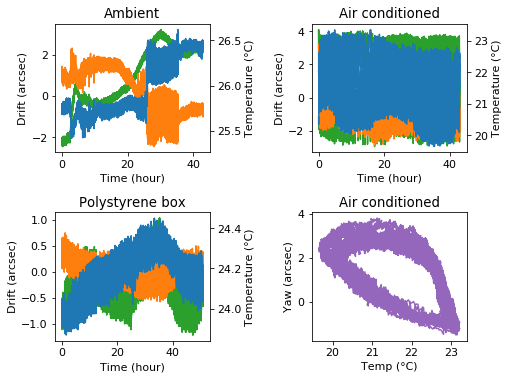

In [22]:
#Plot the drift data. Plot [1, 1] shows the angular drift dependence on temperature shown by the air conditioned subdataset
fig, ax = plt.subplots(2, 2, figsize = (7.20, 5.40))
ax1 = ax[0, 0].twinx()
ax2 = ax[0, 1].twinx()
ax3 = ax[1, 0].twinx()
ax[0, 0].set_xlabel('Time (hour)')
ax[0, 0].set_ylabel('Drift (arcsec)')
ax1.set_ylabel('Temperature (\u00b0C)')
ax[0, 1].set_xlabel('Time (hour)')
ax[0, 1].set_ylabel('Drift (arcsec)')
ax2.set_ylabel('Temperature (\u00b0C)')
ax[1, 0].set_xlabel('Time (hour)')
ax[1, 0].set_ylabel('Drift (arcsec)')
ax3.set_ylabel('Temperature (\u00b0C)')
ax[1, 1].set_xlabel('Temp (\u00b0C)')
ax[1, 1].set_ylabel('Yaw (arcsec)')
ax[0, 0].set_title('Ambient')
ax[0, 1].set_title('Air conditioned')
ax[1, 0].set_title('Polystyrene box')
ax[1, 1].set_title('Air conditioned')

ax1.plot(df_ambient['Time (s)'] / seconds_per_hour, df_ambient['Temperature (°C)'], color = '#2ca02c', linestyle = '-')
ax[0, 0].plot(df_ambient['Time (s)'] / seconds_per_hour, df_ambient['Pitch (arcsec)'], color = '#ff7f0e', linestyle = '-')
ax[0, 0].plot(df_ambient['Time (s)'] / seconds_per_hour, df_ambient['Yaw (arcsec)'], color = '#1f77b4', linestyle = '-')

ax2.plot(df_aircon['Time (s)'] / seconds_per_hour, df_aircon['Temperature (°C)'], color = '#2ca02c', linestyle = '-')
ax[0, 1].plot(df_aircon['Time (s)'] / seconds_per_hour, df_aircon['Pitch (arcsec)'], color = '#ff7f0e', linestyle = '-')
ax[0, 1].plot(df_aircon['Time (s)'] / seconds_per_hour, df_aircon['Yaw (arcsec)'], color = '#1f77b4', linestyle = '-')

ax3.plot(df_box['Time (s)'] / seconds_per_hour, df_box['Temperature (°C)'], color = '#2ca02c', linestyle = '-')
ax[1, 0].plot(df_box['Time (s)'] / seconds_per_hour, df_box['Pitch (arcsec)'], color = '#ff7f0e', linestyle = '-')
ax[1, 0].plot(df_box['Time (s)'] / seconds_per_hour, df_box['Yaw (arcsec)'], color = '#1f77b4', linestyle = '-')

#Temperature dependence over a 10 hours period at the centre of the air conditioned subdataset
ind = (df_aircon['Time (s)'] >= 16.5 * seconds_per_hour) & (df_aircon['Time (s)'] <= 26.5 * seconds_per_hour)
x = df_aircon['Temperature (°C)'][ind].copy().values
y = df_aircon['Yaw (arcsec)'][ind].copy().values
ax[1, 1].plot(x, y, color = '#9467bd', linestyle = '-')

ax[0, 0].set_zorder(1)
ax[0, 0].set_frame_on(False)
ax[0, 1].set_zorder(1)
ax[0, 1].set_frame_on(False)
ax[1, 0].set_zorder(1)
ax[1, 0].set_frame_on(False)

plt.tight_layout()
plt.show()

## Allan deviation plot

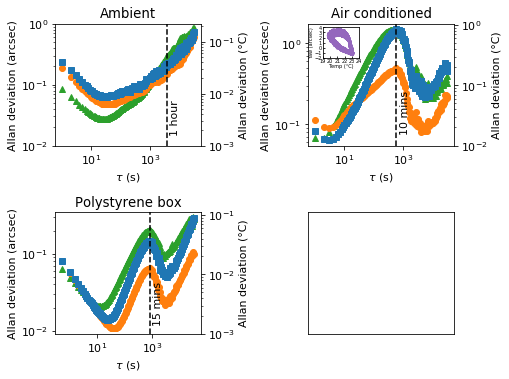

In [23]:
#Plot the Allan deviations calculated in the previous cell. The inset in the graph for the air conditioned subdataset shows the angular drift dependence on temperature
fig, ax = plt.subplots(2, 2, figsize = (7.20, 5.40))
ax2 = ax[0, 0].twinx()
ax3 = ax[0, 1].twinx()
ax4 = ax[1, 0].twinx()
ax5 = ax[0, 1].inset_axes([0.1, 0.72, 0.25, 0.25])
ax[0, 0].set_xlabel(r'$\tau$ (s)')
ax[0, 0].set_ylabel('Allan deviation (arcsec)')
ax2.set_ylabel('Allan deviation (\u00b0C)')
ax[0, 1].set_xlabel(r'$\tau$ (s)')
ax[0, 1].set_ylabel('Allan deviation (arcsec)')
ax3.set_ylabel('Allan deviation (\u00b0C)')
ax[1, 0].set_xlabel(r'$\tau$ (s)')
ax[1, 0].set_ylabel('Allan deviation (arcsec)')
ax4.set_ylabel('Allan deviation (\u00b0C)')
ax5.set_xlabel('Temp (\u00b0C)', fontsize = 5, labelpad = 0.1)
ax5.set_ylabel('Yaw (arcsec)', fontsize = 5, labelpad = 0.1)
ax5.tick_params(labelsize = 5, direction = 'in', length = 2, pad = 1)
ax[1, 1].get_xaxis().set_visible(False)
ax[1, 1].get_yaxis().set_visible(False)
ax[0, 0].set_title('Ambient')
ax[0, 1].set_title('Air conditioned')
ax[1, 0].set_title('Polystyrene box')

ax2.loglog(tau_temp_ambient, allan_temp_ambient, marker = '^', color = '#2ca02c', linestyle = '')
ax[0, 0].loglog(tau_y_ambient, allan_y_ambient, marker = 'o', color = '#ff7f0e', linestyle = '')
ax[0, 0].loglog(tau_x_ambient, allan_x_ambient, marker = 's', color = '#1f77b4', linestyle = '')
ax[0, 0].axvline(seconds_per_hour, color = 'k', linestyle = '--')
ax[0, 0].text(seconds_per_hour * 1.3, 0.02 * np.max(allan_x_ambient), '1 hour', rotation = 90, verticalalignment = 'bottom')

ax3.loglog(tau_temp_aircon, allan_temp_aircon, marker = '^', color = '#2ca02c', linestyle = '')
ax[0, 1].loglog(tau_y_aircon, allan_y_aircon, marker = 'o', color = '#ff7f0e', linestyle = '')
ax[0, 1].loglog(tau_x_aircon, allan_x_aircon, marker = 's', color = '#1f77b4', linestyle = '')
if np.argmax(allan_x_aircon) == np.argmax(allan_y_aircon):
    i = np.argmax(allan_x_aircon)
    ax[0, 1].axvline(tau_x_aircon[i], color = 'k', linestyle = '--')
    ax[0, 1].text(tau_x_aircon[i] * 1.3, 0.05 * np.max(allan_x_aircon), '{:.0f} mins'.format(tau_x_aircon[i] / 60.0), rotation = 90, verticalalignment = 'bottom')

ax4.loglog(tau_temp_box, allan_temp_box, marker = '^', color = '#2ca02c', linestyle = '')
ax[1, 0].loglog(tau_y_box, allan_y_box, marker = 'o', color = '#ff7f0e', linestyle = '')
ax[1, 0].loglog(tau_x_box, allan_x_box, marker = 's', color = '#1f77b4', linestyle = '')
if np.argmax(allan_x_box[10:150]) == np.argmax(allan_y_box[10:150]):
    i = np.argmax(allan_x_box[10:150]) + 10
    ax[1, 0].axvline(tau_x_box[i], color = 'k', linestyle = '--')
    ax[1, 0].text(tau_x_box[i] * 1.3, 0.04 * np.max(allan_x_box), '{:.0f} mins'.format(tau_x_box[i] / 60.0), rotation = 90, verticalalignment = 'bottom')

#Temperature dependence over a 10 hours period at the centre of the air conditioned subdataset
ind = (df_aircon['Time (s)'] >= 16.5 * seconds_per_hour) & (df_aircon['Time (s)'] <= 26.5 * seconds_per_hour)
x = df_aircon['Temperature (°C)'][ind].copy().values
y = df_aircon['Yaw (arcsec)'][ind].copy().values
ax5.plot(x, y, linestyle = '-', color = '#9467bd')
ax5.set_xticks(np.arange(np.floor(np.min(x)), np.ceil(np.max(x)) + 1.0, 1.0))
ax5.set_yticks(np.arange(np.floor(np.min(y)), np.ceil(np.max(y)) + 1.0, 1.0))
ax5.set_xlim([np.floor(np.min(x)), np.ceil(np.max(x))])
ax5.set_ylim([np.floor(np.min(y)), np.ceil(np.max(y))])

ax[0, 0].set_yticks((10**0, 10**-1, 10**-2))
ax[0, 1].set_yticks((10**0, 10**-1))
ax[1, 0].set_yticks((10**-1, 10**-2))
ax2.set_yticks((10**-1, 10**-2, 10**-3))
ax3.set_yticks((10**0, 10**-1, 10**-2))
ax4.set_yticks((10**-1, 10**-2, 10**-3))

ax[0, 0].set_zorder(1)
ax[0, 0].set_frame_on(False)
ax[0, 1].set_zorder(1)
ax[0, 1].set_frame_on(False)
ax[1, 0].set_zorder(1)
ax[1, 0].set_frame_on(False)

plt.tight_layout()
plt.savefig('drift.pdf')
plt.show()

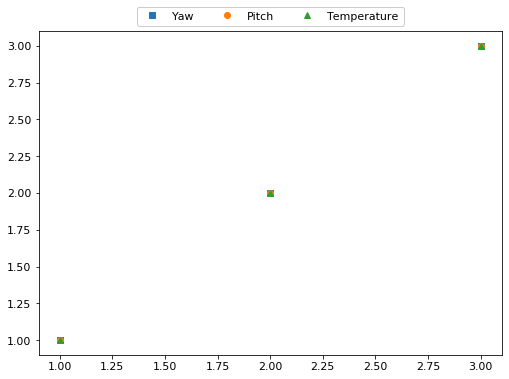

In [24]:
#Generate legends
fig, ax = plt.subplots(1, 1, figsize = (7.20, 5.40))

temp_x = np.array([1, 2, 3])
temp_y = np.array([1, 2, 3])

ax.plot(temp_x, temp_y, marker = 's', linestyle = '', label = 'Yaw')
ax.plot(temp_x, temp_y, marker = 'o', linestyle = '', label = 'Pitch')
ax.plot(temp_x, temp_y, marker = '^', linestyle = '', color = '#2ca02c', label = 'Temperature')

ax.legend(loc = 'lower center', bbox_to_anchor = (0.5, 1), ncol = 3, framealpha = 1)

plt.tight_layout()
plt.savefig('drift_legend.pdf')
plt.show()